In [132]:
!pip install evaluate pythainlp


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [133]:
%matplotlib inline
import pandas
import sklearn
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display
from sklearn.metrics import accuracy_score, classification_report

In [134]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from tqdm import tqdm
from torchmetrics.classification import MultilabelAccuracy
from datasets import Dataset
import pickle
import random
import evaluate
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_stopwords

In [135]:
from huggingface_hub import notebook_login

notebook_login()

ImportError: The `notebook_login` function can only be used in a notebook (Jupyter or Colab) and you need the `ipywidgets` module: `pip install ipywidgets`.

In [136]:
import wandb
wandb.login(key="c6f0c2b20da326f7cd01857887a897f898ba5b4f")

wandb: Currently logged in as: bookpanda. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/idhibhatpankam/.netrc


True

In [138]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
# train_df = pd.read_csv('/kaggle/input/dataset/train.csv')
# test_df = pd.read_csv('/kaggle/input/dataset/test.csv')
train_df.head()

,id,comment,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,0,0,0,0,0,0,0,0,0,0,0,0
1,1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,0,0,0,0,0,0,0,0,0,0,0,0
2,2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,0,0,0,0,0,0,0,0,0,0,0,0
3,3,ปัญหาน้ำท่วมในซอยสวนพลู 1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,1. ซ่อมสายไฟ กรีดขวางทางเท้า,0,0,0,0,0,0,0,0,0,0,0,0


In [139]:
train_df.describe()

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
count,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000
mean,102310.500000,0.209635,0.019969,0.000049,0.016034,0.000117,0.167944,0.034542,0.000406,0.024176,0.018478,0.000059,0.023839
std,59069.427728,0.407049,0.139892,0.006991,0.125608,0.010829,0.373817,0.182616,0.020136,0.153597,0.134672,0.007658,0.152548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51155.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,102310.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,153465.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,204621.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [140]:
def drop_rows(df):
    # drop rows with missing values, duplicates
    print(f"Before dropna: {df.shape}")
    df.dropna(inplace=True)
    df.drop_duplicates("comment", keep="first", inplace=True)
    df = df.reset_index(drop=True)
    print(f"After dropna: {df.shape}")

drop_rows(train_df)
drop_rows(test_df)
print(train_df.shape, test_df.shape)

Before dropna: (204622, 14)
After dropna: (204622, 14)
Before dropna: (10810, 2)
After dropna: (10810, 2)
(204622, 14) (10810, 2)


In [141]:
contacts = train_df.columns[2:]

train_df['label'] = train_df[contacts].apply(lambda x: list(x), axis=1)
train_df.drop(contacts, axis=1, inplace=True)
train_df.drop("id", axis=1, inplace=True)

train_df.head()

,comment,label
0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,ปัญหาน้ำท่วมในซอยสวนพลู 1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,1. ซ่อมสายไฟ กรีดขวางทางเท้า,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [146]:
train_df['label'].value_counts()

label
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    102333
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     42212
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]     32543
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]      5803
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]      4598
                                         ...  
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]         1
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]         1
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]         1
[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]         1
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]         1
Name: count, Length: 73, dtype: int64

In [186]:
# reduce empty label rows from 100k to 10k
no_labels_df = train_df[train_df['label'].apply(lambda x: sum(x) == 0)]
reduced_no_labels_df = no_labels_df.sample(n=10000, random_state=42)
train_df = train_df.drop(no_labels_df.index)
train_df = pd.concat([train_df, reduced_no_labels_df], ignore_index=True)
train_df['label'].value_counts()

label
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    42212
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    32543
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    10000
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]     5803
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]     4598
                                        ...  
[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]        1
[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]        1
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]        1
[0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]        1
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]        1
Name: count, Length: 73, dtype: int64

In [189]:
# increase rare labels to 500 each
per_label_count = 500
label_counts = train_df['label'].value_counts()

rare_labels = label_counts[label_counts < per_label_count].index
rare_labels_df = train_df[train_df['label'].isin(rare_labels)]

In [190]:
rare_labels_df['label'].value_counts()

label
[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]    487
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]    321
[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    288
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]    239
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]    161
                                       ... 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]      1
[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]      1
[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]      1
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]      1
[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]      1
Name: count, Length: 63, dtype: int64

In [191]:
augmented_data = []

for label in rare_labels:
    subset = train_df[train_df['label'].apply(lambda x: x == label)]
    num_needed = per_label_count - len(subset)
    
    # randomly sample with replacement
    sampled_rows = subset.sample(n=num_needed, replace=True, random_state=42)
    
    augmented_data.append(sampled_rows)

train_df = pd.concat([train_df] + augmented_data, ignore_index=True)

In [196]:
print(train_df.shape)
train_df['label'].value_counts()

(141398, 2)


label
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    42212
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]    32543
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    10000
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]     5803
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]     4598
                                        ...  
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]      500
[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]      500
[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]      500
[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]      500
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]      500
Name: count, Length: 73, dtype: int64

In [193]:
contacts

Index(['สำนักงานตำรวจแห่งชาติ', 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย',
       'สภาเด็กและเยาวชนกรุงเทพมหานคร', 'กรมควบคุมมลพิษ', 'กรมสรรพสามิต',
       'การไฟฟ้านครหลวง', 'กรมทางหลวง', 'สำนักงานประกันสุขภาพแห่งชาติ',
       'การประปานครหลวง', 'คณะกรรมการการพัฒนาเศรษฐกิจ',
       'กระทรวงการท่องเที่ยวและกีฬา', 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200'],
      dtype='object')

In [194]:
# stop_words = set(thai_stopwords())
def clean_comment(comment):
    comment = comment.replace('ํา', "ำ") # wangchanberta requirement
    comment = re.sub(r'[^\w\s\u0E00-\u0E7F]', '', comment, flags=re.UNICODE) # only thai, alphanumeric characters
    comment = re.sub(r'[#\n*]', '', comment) # remove #, \n, *
    comment = re.sub(r'\b\d{4,}\b', '', comment) # remove long numbers
    comment = re.sub(r'http[s]?://\S+|www\.\S+', '', comment) # remove urls
    # tokens = word_tokenize(comment)
    # comment = ''.join(token for token in tokens if token not in stop_words)
    comment = re.sub(r'\s+', ' ', comment).strip()

    return comment

In [195]:
print(train_df["comment"][:10])
train_df["comment"] = train_df["comment"].map(clean_comment)
test_df["comment"] = test_df["comment"].map(clean_comment)
print(train_df["comment"][:10])

0    ร้องเรียน รถแท็กซี่ จอดกีดขวางป้ายรถเมล์บริเวณ...
1    พบรถแท็กซี่จอดทิ้งไว้บริเวณถนนถึงสัญญาณไฟช่วงแ...
2    แจ้งปัญหาทางเท้าโดนอู่ซ่อมรถวางของ จอดรถทับทาง...
3    ปัญหารถติดหน้าห่างสรรพสินค้า central eastville...
4               สถานที่รถติดคือถนน ซอยพหลโยธิน18/1ครับ
5    ป้อมตำรวจตรงแยกมิสทีนของเขตสะพานสูงขวางทางเท้า...
6    เส้นทางแยกบางโพ มีการก่อสร้างยังไม่เสร็จสักทีก...
7    ใช่ค่ะ เมื่อวานโดนกับตัวเลยค่ะ รถเกือบล้ม ที่ถ...
8     ฟุตบาทไม่เรียบ ง่ายต่อการสะดุด แบะเกิดอุบัติเหตุ
9    ไฟจราจรสีแดงไม่ทำงาน (แต่สีเขียวทำ) ที่แยกถนนท...
Name: comment, dtype: object
0    ร้องเรียน รถแท็กซี่ จอดกีดขวางป้ายรถเมล์บริเวณ...
1    พบรถแท็กซี่จอดทิ้งไว้บริเวณถนนถึงสัญญาณไฟช่วงแ...
2    แจ้งปัญหาทางเท้าโดนอู่ซ่อมรถวางของ จอดรถทับทาง...
3    ปัญหารถติดหน้าห่างสรรพสินค้า central eastville...
4                สถานที่รถติดคือถนน ซอยพหลโยธิน181ครับ
5    ป้อมตำรวจตรงแยกมิสทีนของเขตสะพานสูงขวางทางเท้า...
6    เส้นทางแยกบางโพ มีการก่อสร้างยังไม่เสร็จสักทีก...
7    ใช่ค่ะ เมื่อวานโดนกับตัวเลยค่ะ 

In [197]:
test_df["comment"]

0        ไม่มีทางเท้าคนเดินจากสะพานกรุงธนบุรีไปวัดราชผา...
1        อันนี้ภาพทางเข้าถ่ายไว้นานแล้วค่ะ ในซอยถนนจะเป...
2                                       ขยะที่แยกสะพานควาย
3        ช่วงเร่งคืนพื้นที่ช่องจราจรถนนแจ้งวัฒนะ ช่วงวิ...
4        ไฟถนนไม่ติด เป็นทางยาว คนเดินถนนลำบากมาก ถนนรั...
                               ...                        
10805    มีแมวจรจัด จำนวนมาก รบกวน กรมสาธารณสุข ส่งทีมง...
10806    ปัญหา เนื่องจาก ประชาชนแจ้งว่าพบทัวร์เถื่อน มี...
10807    สวนสมเด็จย่า 84 ติดทางเข้า MRT พหลโยธินมีสุนัข...
10808    A big thank you I wrote to you around 2 weeks ...
10809    บริเวณวินรถจักรยานยนต์ ปากซอยราชปรารภ 8 วินวัฒ...
Name: comment, Length: 10810, dtype: object

In [198]:
def plot_sample_length(lengths: list[int], title: str):
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")
    print(f"Mean length: {np.mean(lengths):.2f}")
    print(f"Median length: {np.median(lengths)}")

    plt.hist(lengths, bins=20, edgecolor='black')
    plt.xlabel('Number of tokens')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

In [199]:
train_lengths = [len(word_tokenize(d)) for d in tqdm(train_df['comment'])]
test_lengths = [len(word_tokenize(d)) for d in tqdm(test_df['comment'])]

100%|██████████| 10810/10810 [00:03<00:00, 3412.29it/s]


Min length: 1
Max length: 1660
Mean length: 48.61
Median length: 33.0


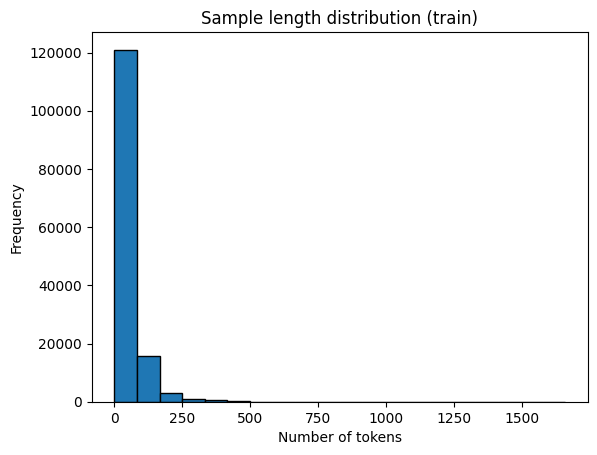

In [200]:
plot_sample_length(train_lengths, 'Sample length distribution (train)')

Min length: 1
Max length: 1299
Mean length: 46.36
Median length: 31.0


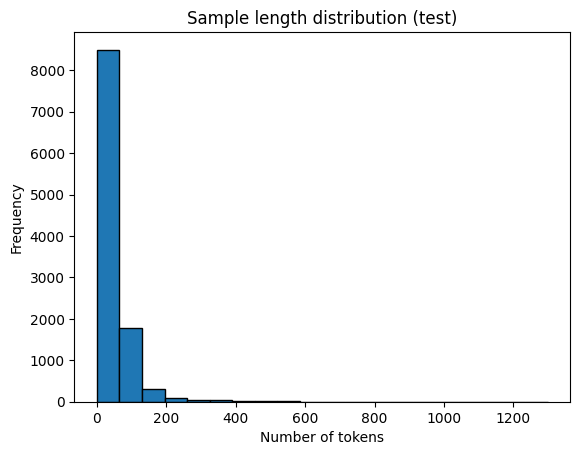

In [201]:
plot_sample_length(test_lengths, 'Sample length distribution (test)')

In [202]:
def count_exceeded_length(lengths: list[int], max_length: int):
    exceed = len([l for l in lengths if l > max_length])
    print(f"Number of samples exceeding {max_length} tokens: {exceed}")
    print(f"Percentage of samples exceeding {max_length} tokens: {exceed / len(lengths) * 100:.2f}%")

max_length = 128
print("TRAIN")
count_exceeded_length(train_lengths, max_length)
print("\nTEST")
count_exceeded_length(test_lengths, max_length)

TRAIN
Number of samples exceeding 128 tokens: 8465
Percentage of samples exceeding 128 tokens: 5.99%

TEST
Number of samples exceeding 128 tokens: 559
Percentage of samples exceeding 128 tokens: 5.17%


In [203]:
train_data = train_df.copy().to_numpy()
test_data = test_df.copy().to_numpy()

label_2_idx = dict(zip(contacts, range(len(contacts))))
idx_2_label = dict(zip(range(len(contacts)), contacts))

print("Create Mappings")
display(idx_2_label)
display(label_2_idx)

# print("Before Mappings")
# display(data[:, 1])
# data[:,1] = np.vectorize(label_2_num_map.get)(data[:,1])
# print("After Mappings")
# display(data[:, 1])

Create Mappings


{0: 'สำนักงานตำรวจแห่งชาติ',
 1: 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย',
 2: 'สภาเด็กและเยาวชนกรุงเทพมหานคร',
 3: 'กรมควบคุมมลพิษ',
 4: 'กรมสรรพสามิต',
 5: 'การไฟฟ้านครหลวง',
 6: 'กรมทางหลวง',
 7: 'สำนักงานประกันสุขภาพแห่งชาติ',
 8: 'การประปานครหลวง',
 9: 'คณะกรรมการการพัฒนาเศรษฐกิจ',
 10: 'กระทรวงการท่องเที่ยวและกีฬา',
 11: 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200'}

{'สำนักงานตำรวจแห่งชาติ': 0,
 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย': 1,
 'สภาเด็กและเยาวชนกรุงเทพมหานคร': 2,
 'กรมควบคุมมลพิษ': 3,
 'กรมสรรพสามิต': 4,
 'การไฟฟ้านครหลวง': 5,
 'กรมทางหลวง': 6,
 'สำนักงานประกันสุขภาพแห่งชาติ': 7,
 'การประปานครหลวง': 8,
 'คณะกรรมการการพัฒนาเศรษฐกิจ': 9,
 'กระทรวงการท่องเที่ยวและกีฬา': 10,
 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200': 11}

In [21]:
def set_random_seed(seed: int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

In [22]:
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, revision='main', model_max_length=128)

tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

In [23]:
X_train_tokens = tokenizer(train_data[:,0].tolist(), truncation=True, padding=True)
X_test_tokens = tokenizer(test_data[:,1].tolist(), truncation=True, padding=True)
num_labels = len(label_2_idx)

In [24]:
y_train = np.array(train_data[:,1].tolist(), dtype=np.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)

# y_train_np = y_train.numpy()
# # new column: 1 if the row is all zeros, else 0
# new_column = np.where(np.all(y_train_np == 0, axis=1), 1, 0).reshape(-1, 1)
# y_train_np = np.hstack([y_train_np, new_column])

# y_train = torch.tensor(y_train_np, dtype=torch.float32)

y_test = np.array([[0] * 12 for _ in range(test_data.shape[0])], dtype=np.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

y_train.shape, y_test.shape

(torch.Size([204622, 12]), torch.Size([10810, 12]))

In [25]:
train_dataset = Dataset.from_dict({
    "input_ids": X_train_tokens["input_ids"],
    "attention_mask": X_train_tokens["attention_mask"],
    "labels": y_train
})

test_dataset = Dataset.from_dict({
    "input_ids": X_test_tokens["input_ids"],
    "attention_mask": X_test_tokens["attention_mask"],
    "labels": y_test
})

In [26]:
num_labels = 12
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

model.safetensors:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
training_args = TrainingArguments(
    output_dir="multi_label_text_classification_wangchanberta_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

In [28]:
classifier_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):
   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return classifier_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))

In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-29-217194651456>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.056400,0.107774,0.960584,0.000000,0.000000,0.000000
2,0.049700,0.107842,0.960900,0.000000,0.000000,0.000000
3,0.046700,0.113548,0.959921,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 

TrainOutput(global_step=19185, training_loss=0.055736577588504636, metrics={'train_runtime': 8927.0112, 'train_samples_per_second': 68.765, 'train_steps_per_second': 2.149, 'total_flos': 4.038235822089216e+16, 'train_loss': 0.055736577588504636, 'epoch': 3.0})

In [79]:
import shutil

shutil.make_archive("/kaggle/working/checkpoint-6395", "zip", "/kaggle/working/multi_label_text_classification_wangchanberta_model/checkpoint-6395")


'/kaggle/working/checkpoint-6395.zip'

In [40]:
predictions = trainer.predict(test_dataset)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
import pickle

with open('predictions_50.pkl', 'wb') as f:
    pickle.dump(predictions, f)

In [45]:
logits = torch.tensor(predictions.predictions)
probs = torch.sigmoid(logits)
pred_labels = (probs > 0.40).int().tolist()
pred_df = pd.DataFrame(pred_labels, columns=contacts)

test_df = pd.read_csv('/kaggle/input/dataset/test.csv')
output_df = pd.concat([test_df["id"], pred_df], axis=1)

In [46]:
output_df.to_csv('submission.csv', index=False)

In [47]:
output_df

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,1,0,0,0,0,0
4,4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10805,10805,0,0,0,0,0,0,0,0,0,0,0,0
10806,10806,0,0,0,0,0,0,0,0,0,0,0,0
10807,10807,0,0,0,0,0,0,0,0,0,0,0,0
10808,10808,1,0,0,0,0,0,0,0,0,0,0,0
